In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)

In [7]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [9]:
parameters = {
    'optimizer_params': {'beta1': 0.9, 'beta2': 0.98, 'epsilon': 10e-9},
    'lr_policy_params': {
        'warmup_steps': 40000,
    },
}

def noam_schedule(step, learning_rate, channels, warmup_steps=4000):
    return learning_rate * channels ** -0.5 * \
            tf.minimum(step ** -0.5, step * warmup_steps ** -1.5)

def learning_rate_scheduler(global_step):
    return transformer_schedule(
        tf.cast(global_step, tf.float32),
        config.channels,
        **parameters['lr_policy_params'],
    )

In [21]:
config.__dict__

{'mel': 80,
 'factor': 2,
 'neck': 160,
 'vocabs': 66,
 'temperature': 0.333,
 'channels': 192,
 'prenet_kernel': 5,
 'prenet_layers': 3,
 'prenet_groups': 4,
 'prenet_dropout': 0.5,
 'block_num': 6,
 'block_ffn': 768,
 'block_heads': 2,
 'block_dropout': 0.1,
 'flow_groups': 4,
 'flow_block_num': 12,
 'wavenet_block_num': 4,
 'wavenet_cycle': 1,
 'wavenet_kernel_size': 5,
 'wavenet_dilation': 1,
 'dur_kernel': 3,
 'dur_layers': 2,
 'dur_dropout': 0.1}

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-5).minimize(loss)

In [11]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'model/mul_89:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 3.16 s, sys: 206 ms, total: 3.37 s
Wall time: 2.56 s


In [24]:
for k in range(100):
    o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})
    print(k, o)

0 [-0.3452416, {'nll': -0.6147642, 'durloss': 0.2695226}, None]
1 [-0.37006316, {'nll': -0.6182613, 'durloss': 0.24819812}, None]
2 [-0.36028975, {'nll': -0.6232129, 'durloss': 0.26292312}, None]
3 [-0.3637225, {'nll': -0.6246279, 'durloss': 0.26090539}, None]
4 [-0.29575592, {'nll': -0.62299937, 'durloss': 0.32724345}, None]
5 [-0.31508756, {'nll': -0.63018394, 'durloss': 0.31509638}, None]
6 [-0.34693784, {'nll': -0.63525194, 'durloss': 0.2883141}, None]
7 [-0.34989706, {'nll': -0.6299924, 'durloss': 0.28009537}, None]
8 [-0.33791023, {'nll': -0.633808, 'durloss': 0.29589778}, None]
9 [-0.350506, {'nll': -0.6356213, 'durloss': 0.2851153}, None]
10 [-0.37251988, {'nll': -0.63249123, 'durloss': 0.25997135}, None]
11 [-0.36047757, {'nll': -0.6416061, 'durloss': 0.28112853}, None]
12 [-0.368831, {'nll': -0.63921416, 'durloss': 0.27038315}, None]
13 [-0.37979347, {'nll': -0.64559454, 'durloss': 0.26580107}, None]
14 [-0.34377143, {'nll': -0.6435407, 'durloss': 0.29976925}, None]
15 [-0.36

In [25]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 767 ms, sys: 192 ms, total: 959 ms
Wall time: 218 ms


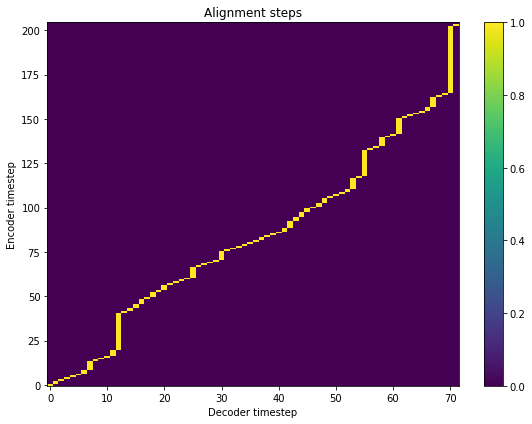

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [31]:
o = sess.run([mel, mellen], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                        mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

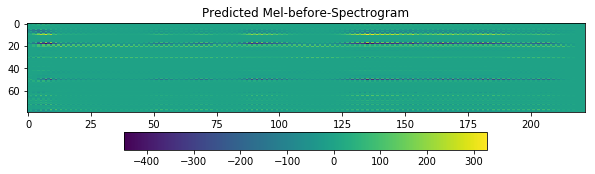

In [32]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [29]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [23]:
!ls -lh test

total 282864
-rw-r--r--  1 huseinzolkepli  staff    77B Oct  9 14:25 checkpoint
-rw-r--r--  1 huseinzolkepli  staff   109M Oct  9 14:25 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff    33K Oct  9 14:25 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff    29M Oct  9 14:25 model.ckpt.meta
